In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

device = "cuda"
from pathlib import Path


# Data download
Here, we download the data and unzip it. Remove the part of the dataset we do nat want to use (images with length 8). Then we make a 75/25 train-test split.

In [ ]:
!wget -nvc https://hessel.b-cdn.net/dataset-deeplearning-2024.zip
!unzip -nq dataset-deeplearning-2024.zip


2024-05-04 12:44:48 URL:https://hessel.b-cdn.net/dataset-deeplearning-2024.zip [320935682/320935682] -> "dataset-deeplearning-2024.zip" [1]


In [ ]:
!rm -r /content/CAPTCHA/synthesized_data/len_8_train/
!rm -r /content/CAPTCHA/synthesized_data/len_8_test/

In [ ]:
# Define the path to the directory containing CAPTCHA data.
data_path = "/content/CAPTCHA/synthesized_data/"

# Initialize an empty list to store the file paths of images.
image_fns = []

# Define a function to recursively get all files in a given directory.
def get_recursive_files(directory):
    # Convert the directory string to a Path object to use Pathlib's methods.
    path = Path(directory)
    # Return a generator that yields all files and directories in the path, recursively.
    return path.rglob('*')

# Loop over each path yielded by the get_recursive_files function.
for file_path in get_recursive_files(data_path):
    # Check if the current path is a file (not a directory).
    if file_path.is_file():
        # If it's a file, convert the path to a string and add it to the image_fns list.
        image_fns.append(str(file_path))

In [ ]:
# Print the total number of image files collected in the image_fns list.
print(f"Total dataset: {len(image_fns)}")

# Split the list of image file paths into training and testing subsets using a random seed.
# This ensures that the split between training and testing data is reproducible.
image_fns_train, image_fns_test = train_test_split(image_fns, random_state=0)

# Print the number of image files in the training set and testing set.
print(f"Train set: {len(image_fns_train)} \nTest set: {len(image_fns_test)}")

Total dataset: 44004
Train set: 33003 
Test set: 11001


# Character maps
Here, we want to find the number of unique characters which are our vocabulary.

In [ ]:
# Create a list of image filenames without their file extension by splitting on the dot and taking the first part.
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]

# Concatenate all the filenames into a single string.
image_ns = "".join(image_ns)

# Create a sorted list of unique characters from the concatenated filenames to form a set of all possible characters.
letters = sorted(list(set(list(image_ns)))) # Create set to remove duplicates

# Create a vocabulary list that includes a hyphen (often used as a padding character) and the sorted letters.
vocabulary = ["-"] + letters

# Create a dictionary to map indices to characters, useful for decoding outputs in models.
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}

# Create a dictionary to map characters to indices, useful for encoding inputs for models.
char2idx = {v:k for k,v in idx2char.items()}

# Print the size of the vocabulary, which includes the unique characters plus the hyphen.
print(f"Vocabulary size: {len(vocabulary)}")


Vocabulary size: 65


# Create dataloader
Here, we create the dataloader and do some preprocessing.



In [ ]:
batch_size = 800

In [ ]:
# Define a class CAPTCHADataset that inherits from the Pytiorch Dataset class
class CAPTCHADataset(Dataset):

    # Constructor to initialize the dataset with a list of image filenames.
    def __init__(self, image_fns):
        self.image_fns = image_fns  # Store the list of image file paths.

    # Return the total number of images in the dataset.
    def __len__(self):
        return len(self.image_fns)

    # Method to retrieve an item at the specified index in the dataset.
    def __getitem__(self, index):
        image_fn = self.image_fns[index]  # Get the file path of the image at the given index.
        image = Image.open(image_fn).convert('RGB')  # Open and convert the image to RGB color mode.
        image = self.transform(image)  # Apply transformations to the image.
        text = image_fn.split("/")[-1].split(".")[0].split("_")[0]  # Extract the text from the filename.
        return image, text  # Return the transformed image and the extracted text as a tuple.

    # Define a method to apply transformations to an image.
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),  # Convert the image to a tensor which is suitable for model input.
        ])
        image_tensor = transform_ops(image)  # Apply the defined transformations.
        return image_tensor  # Return the transformed image tensor.


In [ ]:
# Create an instance of the CAPTCHADataset class with the training image filenames.
trainset = CAPTCHADataset(image_fns_train)

# Create an instance of the CAPTCHADataset class with the testing image filenames.
testset = CAPTCHADataset(image_fns_test)

# Create a DataLoader for the training set to handle batch processing, shuffling, and parallel loading of data.
# 'batch_size' determines how many samples are processed before the model is updated,
# 'num_workers' specifies how many subprocesses to use for data loading (8 in this case for faster performance),
# 'shuffle=True' randomizes the order of data which is beneficial for training models to prevent sequence bias.
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=8, shuffle=True)

# Create a DataLoader for the testing set. Shuffling is not needed here because the order of testing data does not affect the results,
# but parallel loading is still used to speed up the processing.
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=8, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


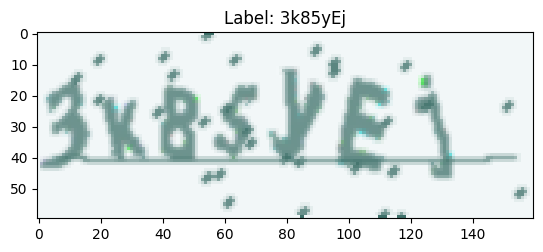

In [ ]:
# Create an instance of the CAPTCHADataset class with all image filenames.
dataset = CAPTCHADataset(image_fns)

# Retrieve the first image and its label from the dataset.
image, label = dataset[0]

# Permute the dimensions of the image tensor from (C, H, W) format to (H, W, C) format for display.
# This reordering is necessary because PyTorch uses channel-first images, while matplotlib expects channel-last images.
image = image.permute(1, 2, 0).numpy()

# Use matplotlib to plot the image.
plt.imshow(image)  # Display the image using the default color map.
plt.title(f"Label: {label}")  # Set the title of the plot to show the label of the image.
plt.show()  # Display the plot.


# Model definition

In [ ]:
# Calculate the number of unique characters in the dataset, which is the size of the character-index mapping dictionary.
num_chars = len(char2idx)

# Set the number of hidden units in the RNN to 256. This value determines the size of the hidden state vector in the RNN layers.
rnn_hidden_size = 256

# Initialize a ResNet-18 model pre-trained on the ImageNet dataset.
# This model is commonly used as a feature extractor in various image processing tasks.
resnet = resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


In [ ]:
# Define a class CRNN that inherits from nn.Module to create a custom neural network architecture.
class CRNN(nn.Module):

    # Constructor for the CRNN class, initializing the CNN and RNN layers along with other parameters.
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        super(CRNN, self).__init__()
        self.num_chars = num_chars  # Number of possible output characters.
        self.rnn_hidden_size = rnn_hidden_size  # Number of units in the hidden layer of the RNN.
        self.dropout = dropout  # Dropout rate for regularization.

        # CNN Part 1: Use the first parts of a pre-trained ResNet model, stopping before the last 3 layers.
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)

        # CNN Part 2: Custom convolutional layer to further process features.
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)  # Linear layer to reduce the feature dimensions.

        # RNN layers: Using two GRU layers to capture dependencies in the sequence data.
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size,
                           hidden_size=rnn_hidden_size,
                           bidirectional=True,
                           batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size,
                           hidden_size=rnn_hidden_size,
                           bidirectional=True,
                           batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)  # Final linear layer to predict characters.

    # Forward pass through the network.
    def forward(self, batch):
        batch = self.cnn_p1(batch)  # Process batch through the first part of the CNN.

        batch = self.cnn_p2(batch)  # Further process with custom convolutional layer.

        # Permute and reshape the batch to align with the requirements of the RNN input.
        batch = batch.permute(0, 3, 1, 2)
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1)  # Flatten the batch for the RNN.

        batch = self.linear1(batch)  # Reduce dimensionality before feeding into RNN.

        batch, hidden = self.rnn1(batch)  # First RNN layer.
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]  # Combine outputs for bidirectionality.

        batch, hidden = self.rnn2(batch)  # Second RNN layer.

        batch = self.linear2(batch)  # Final linear layer to output predictions for each timestep.

        batch = batch.permute(1, 0, 2)  # Permute to match expected output format [T, batch_size, num_classes].
        return batch


In [ ]:
# Define a function to initialize the weights of the neural network modules passed to it.
def weights_init(m):
    # Get the class name of the module.
    classname = m.__class__.__name__

    # Check if the module is an instance of nn.Linear, nn.Conv2d, or nn.Conv1d.
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        # Initialize weights using the Xavier uniform initialization method.
        # This is a good default choice for layers with Sigmoid and Tanh activation functions.
        torch.nn.init.xavier_uniform_(m.weight)
        # If the layer has a bias term, initialize it to 0.01.
        if m.bias is not None:
            m.bias.data.fill_(0.01)

    # Check if the class name contains 'BatchNorm', which indicates a Batch Normalization layer.
    elif classname.find('BatchNorm') != -1:
        # Initialize the weights of the BatchNorm layer to a normal distribution with mean = 1 and std = 0.02.
        # This setting helps keep the output of the network in a controlled scale during initial phases of training.
        m.weight.data.normal_(1.0, 0.02)
        # Set the biases of the BatchNorm layer to 0.
        m.bias.data.fill_(0)


In [ ]:
# Instantiate the CRNN class with the number of characters and the specified RNN hidden size.
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)

# Apply the custom weights_init function to all modules of the CRNN model.
# This function will initialize weights and biases according to the specified rules in weights_init.
crnn.apply(weights_init)

# Move the CRNN model to the specified 'device'. This device could be a GPU or CPU,
# which is determined by whether CUDA is available and appropriately set in the 'device' variable.
crnn = crnn.to(device)


# Setup CTC Loss function

In [ ]:
# Initialize the Connectionist Temporal Classification (CTC) loss function.
# The 'blank' parameter specifies the label used for the "blank" symbol in the CTC algorithm.
# Here, it's set to 0, which should correspond to the "blank" class in your label encoding.
criterion = nn.CTCLoss(blank=0) #TODO: checken of dit klopt


In [ ]:
# Define a function to encode a batch of text labels for training with CTC loss.
def encode_text_batch(text_batch):
    # Calculate the length of each text in the batch.
    # This list of lengths will be used to segment the concatenated targets into individual ones later in the CTC loss calculation.
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)  # Convert the list of lengths to a PyTorch tensor of type Int.

    # Concatenate all text labels into a single string.
    # This step is necessary because CTC loss requires a single tensor as the target sequence.
    text_batch_concat = "".join(text_batch)

    # Convert each character in the concatenated string to its corresponding index using the char2idx dictionary.
    # This dictionary maps characters to numerical indices which are required for numerical processing in neural networks.
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)  # Convert the list of indices to a PyTorch tensor of type Int.

    # Return the tensor of concatenated targets and their corresponding lengths.
    return text_batch_targets, text_batch_targets_lens


In [ ]:
# Define a function to compute the loss for a batch of text predictions using Connectionist Temporal Classification (CTC) loss.
def compute_loss(text_batch, text_batch_logits):
    """
    Compute the CTC loss between the predicted logits and the ground truth labels.

    Parameters:
    text_batch : list of strings
        Each string in the list corresponds to the ground truth text for one sample in the batch.
    text_batch_logits : Tensor
        A tensor containing the raw output logits from a model. It should have the shape [T, batch_size, num_classes],
        where T is the maximum sequence length, batch_size is the number of samples in the batch, and num_classes is
        the number of character classes including the blank label used in CTC.

    Returns:
    loss : Tensor
        A tensor containing the computed CTC loss for the batch.
    """

    # Apply log softmax to the logits on the last dimension (num_classes) to get log probabilities.
    # This step is necessary because CTC loss expects log probabilities.
    text_batch_logps = F.log_softmax(text_batch_logits, 2)  # Shape: [T, batch_size, num_classes]

    # Create a tensor that contains the lengths of the log probabilities for each sample in the batch.
    # All lengths are set to T, the maximum length of the log probabilities tensor.
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),),
                                       fill_value=text_batch_logps.size(0),
                                       dtype=torch.int32).to(device)  # Shape: [batch_size]

    # Encode the batch of ground truth texts into a format suitable for CTC loss calculation.
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)

    # Calculate the CTC loss using the processed log probabilities, encoded targets,
    # lengths of log probabilities, and lengths of each ground truth text.
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    # Return the computed loss.
    return loss


## 6. Train model

In [ ]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [ ]:
# Define the optimizer for updating the parameters of the CRNN model during training.
# Adam optimizer is used with a specified learning rate and weight decay.
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)

# Define a learning rate scheduler to adjust the learning rate during training based on validation loss.
# ReduceLROnPlateau scheduler reduces the learning rate when the monitored quantity (validation loss) has stopped improving.
# Patience parameter determines the number of epochs with no improvement after which learning rate will be reduced.
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)


In [ ]:
# Reinitialize the CRNN model with the specified number of characters and hidden size for the RNN layer.
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)

# Apply the weight initialization function to the model.
crnn.apply(weights_init)

# Move the model to the specified device (e.g., GPU if available) for training or evaluation.
crnn = crnn.to(device)

In [ ]:
# Initialize lists to store losses and updates statistics for monitoring training progress.
epoch_losses = []
iteration_losses = []
num_updates_epochs = []

# Begin training over a specified number of epochs.
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = []  # List to store losses for each iteration within the current epoch.
    num_updates_epoch = 0  # Counter to track the number of successful update steps within the current epoch.

    # Loop over each batch of images and corresponding texts from the training loader.
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()  # Reset the gradients of all model parameters to zero.

        # Forward pass: compute predicted logits by passing the batch of images to the model.
        text_batch_logits = crnn(image_batch.to(device))

        # Compute the loss between the predicted logits and the ground truth texts.
        loss = compute_loss(text_batch, text_batch_logits)

        # Extract the scalar value of the loss for monitoring and checks.
        iteration_loss = loss.item()

        # Skip the backward pass if the loss is NaN or infinite, which can happen if there are numerical issues during training.
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue

        # Increment the update counter since the current iteration will contribute to model training.
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)  # Append the iteration loss to the tracking list.
        epoch_loss_list.append(iteration_loss)   # Append the loss to the list for this epoch.

        # Backward pass: compute the gradient of the loss with respect to all trainable parameters.
        loss.backward()

        # Clip the gradients to a specified norm value to prevent exploding gradients.
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)

        # Update the model parameters according to the computed gradients.
        optimizer.step()

    # Calculate the mean loss for the epoch using the collected losses.
    epoch_loss = np.mean(epoch_loss_list)

    # Output training status to help with monitoring progress.
    print(f"Epoch:{epoch}    Loss:{epoch_loss:.4f}    NumUpdates:{num_updates_epoch}")

    # Append the mean epoch loss to the list for overall tracking.
    epoch_losses.append(epoch_loss)

    # Append the number of updates to the list for overall tracking.
    num_updates_epochs.append(num_updates_epoch)

    # Update the learning rate scheduler based on the epoch loss.
    lr_scheduler.step(epoch_loss)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch:1    Loss:4.2522    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:2    Loss:4.1452    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:3    Loss:3.9173    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:4    Loss:3.5177    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:5    Loss:3.0789    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:6    Loss:2.7618    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:7    Loss:2.5756    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:8    Loss:2.4704    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:9    Loss:2.4013    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:10    Loss:2.3528    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:11    Loss:2.2924    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:12    Loss:2.2426    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:13    Loss:2.2010    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:14    Loss:2.1731    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:15    Loss:2.1357    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:16    Loss:2.1029    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:17    Loss:2.0721    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:18    Loss:2.0647    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:19    Loss:2.0608    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:20    Loss:2.0191    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:21    Loss:2.0062    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:22    Loss:1.9916    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:23    Loss:1.9801    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:24    Loss:1.9657    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:25    Loss:1.9759    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:26    Loss:1.9663    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:27    Loss:1.9697    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:28    Loss:1.9546    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:29    Loss:1.9559    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:30    Loss:1.9239    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:31    Loss:1.9147    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:32    Loss:1.9202    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:33    Loss:1.9171    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:34    Loss:1.9850    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:35    Loss:1.9332    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:36    Loss:1.9175    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:37    Loss:1.9071    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:38    Loss:1.8877    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:39    Loss:1.8650    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:40    Loss:1.8629    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:41    Loss:1.8722    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:42    Loss:1.8954    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:43    Loss:1.9277    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:44    Loss:1.9213    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:45    Loss:1.9071    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:46    Loss:1.8813    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:47    Loss:1.8158    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:48    Loss:1.7797    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:49    Loss:1.7710    NumUpdates:42


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:50    Loss:1.7642    NumUpdates:42


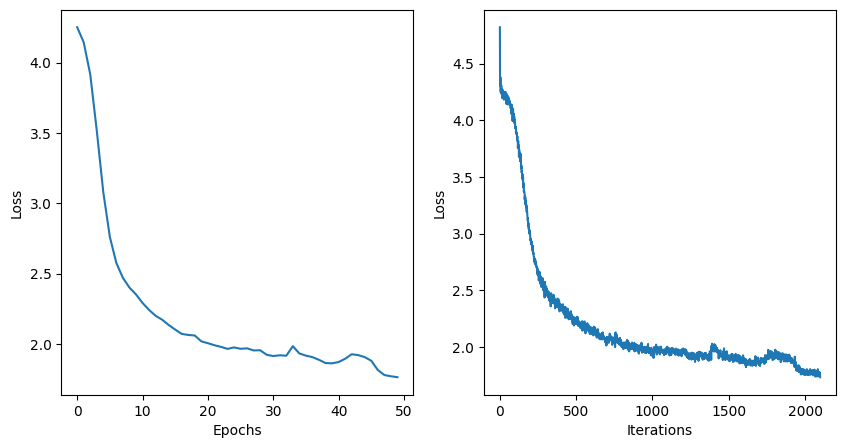

In [ ]:
# Create a figure and a 1x2 grid of subplots with a specific size.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the epoch losses on the first subplot.
ax1.plot(epoch_losses)  # Plot the list 'epoch_losses' which tracks loss per epoch.
ax1.set_xlabel("Epochs")  # Set the x-axis label of the first subplot to 'Epochs'.
ax1.set_ylabel("Loss")  # Set the y-axis label of the first subplot to 'Loss'.

# Plotting the iteration losses on the second subplot.
ax2.plot(iteration_losses)  # Plot the list 'iteration_losses' which tracks loss per iteration.
ax2.set_xlabel("Iterations")  # Set the x-axis label of the second subplot to 'Iterations'.
ax2.set_ylabel("Loss")  # Set the y-axis label of the second subplot to 'Loss'.

# Display the plots.
plt.show()


In [ ]:
# here we save the model to drive
torch.save(crnn, '/model_50.pth')


# Model evaluation

In [ ]:
# Define a function to decode the model's raw logits into readable text predictions.
def decode_predictions(text_batch_logits):
    # Apply softmax to convert logits to probabilities and get the indices of max probabilities.
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2)  # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T  # Transpose to [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        # Convert numerical indices to characters using the idx2char dictionary.
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)  # Join the list of characters into a single string.
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new


In [ ]:
# Initialize a DataFrame to store actual and predicted labels for the training data.
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        # Obtain logits from the CRNN model and move the logits to the CPU for decoding.
        text_batch_logits = crnn(image_batch.to(device))  # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        df = pd.DataFrame({'actual': text_batch, 'prediction': text_batch_pred})
        results_train = pd.concat([results_train, df])  # Append new predictions to the DataFrame.
results_train = results_train.reset_index(drop=True)  # Reset the DataFrame index after all batches are processed.

  0%|          | 0/2063 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# Similar process for test data.
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device))
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        df = pd.DataFrame({'actual': text_batch, 'prediction': text_batch_pred})
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/688 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# Print out the shape of the training results DataFrame and the first few rows to inspect.
print(results_train.shape)
results_train.head()

(33003, 2)


,actual,prediction
0,NPuatBk,NPaatBk
1,3XXb,3X-Xb--
2,az3d0un,az3d00n
3,s5H9m,s5H99mm
4,4bTc,4bTTc--


In [ ]:
# Print out the shape of the testing results DataFrame and the first few rows to inspect.
print(results_test.shape)
results_test.head()

(11001, 2)


,actual,prediction
0,SDLR,SSLRR--
1,8ZdwuLJ,8ZdwuLJ
2,KiwPQr,KiwPPQr
3,XgUueeS,XgUUeeS
4,o9jPlqk,o9jPPqk


In [ ]:
# Function to remove consecutive duplicate characters, except for hyphens, from the predictions.
def remove_duplicates(text):
    if len(text) > 1:
        # Remove duplicates but keep the first occurrence.
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

# Function to correct predictions by splitting at hyphens and removing duplicates from each segment.
def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
# Apply the 'correct_prediction' function to each item in the 'prediction' column of the results_train DataFrame.
# This function processes each predicted string to remove consecutive duplicate characters and unnecessary segments.
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)

# Display the first few rows of the results_train DataFrame to inspect the changes.
# This will show the actual labels, the raw predictions, and the corrected predictions side by side.
results_train.head()

,actual,prediction,prediction_corrected
0,NPuatBk,NPaatBk,NPatBk
1,3XXb,3X-Xb--,3XXb
2,az3d0un,az3d00n,az3d0n
3,s5H9m,s5H99mm,s5H9m
4,4bTc,4bTTc--,4bTc


In [ ]:
# Apply the 'correct_prediction' function to each item in the 'prediction' column of the results_test DataFrame.
# This function is designed to clean up the predictions by removing consecutive duplicate characters
# and correctly handling segments separated by hyphens.
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)

# Display the first few rows of the results_test DataFrame to check the initial results.
# This preview will include columns for actual labels, raw predictions, and the corrected predictions,
# providing a quick overview of how well the correction function is performing.
results_test.head()


,actual,prediction,prediction_corrected
0,SDLR,SSLRR--,SLR
1,8ZdwuLJ,8ZdwuLJ,8ZdwuLJ
2,KiwPQr,KiwPPQr,KiwPQr
3,XgUueeS,XgUUeeS,XgUeS
4,o9jPlqk,o9jPPqk,o9jPqk


In [ ]:
# save prediction results
results_train.to_csv('./results_train.csv', index=False)
results_test.to_csv('./results_test.csv', index=False)

# Model Metrics

In [ ]:
# Filter the results_test DataFrame to include only rows where the actual labels differ from the corrected predictions.
# This identifies cases where the model made mistakes in its predictions after post-processing.
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]

# Display the mistakes_df DataFrame to view the rows where the model's predictions did not match the actual labels.
# This DataFrame contains columns for actual labels, raw predictions, and corrected predictions, allowing for detailed inspection.
mistakes_df


,actual,prediction,prediction_corrected
2,u1IAAXF,uuuAAFF,uAF
3,PG04UU,PG044-U,PG04U
5,Bbb2rk,Bbb22rk,Bb2rk
9,Rg0wO,RgOwOOO,RgOwO
16,tFZ5dm,tFF5ddm,tF5dm
...,...,...,...
10986,iPfP7H,iPPPP7H,iP7H
10987,xMxwbn,xxxwbbn,xwbn
10990,C0yLVj,CCyLVVj,CyLVj
10995,KjtL1DE,Kjtt1DE,Kjt1DE


In [ ]:
# Calculate the counts of different lengths of corrected predictions in the 'prediction_corrected' column of mistakes_df.
# This counts how many mistakes were made for each length of corrected prediction.
# The 'str.len()' function computes the length of each string in the 'prediction_corrected' column.
# The 'value_counts()' function then counts the occurrences of each unique length.
print(mistakes_df['prediction_corrected'].str.len().value_counts())


prediction_corrected
5    1109
6     997
4     845
3     620
7     140
2     109
1      10
Name: count, dtype: int64


In [ ]:
# Define a mask that filters the mistakes_df DataFrame to include only rows where the length of the corrected prediction is 5.
mask = mistakes_df['prediction_corrected'].str.len() == 5

# Apply the mask to the mistakes_df DataFrame to select only the rows where the length of the corrected prediction is 5.
# This filters the DataFrame to focus specifically on mistakes of length 5.
filtered_mistakes_df = mistakes_df[mask]

# Display the filtered DataFrame to inspect the mistakes where the corrected prediction length is 5.
filtered_mistakes_df

,actual,prediction,prediction_corrected
3,PG04UU,PG044-U,PG04U
5,Bbb2rk,Bbb22rk,Bb2rk
9,Rg0wO,RgOwOOO,RgOwO
16,tFZ5dm,tFF5ddm,tF5dm
21,We3pCCh,We3pCCC,We3pC
...,...,...,...
10954,lTvXfNZ,lTvXXNN,lTvXN
10957,mYHMyF4,mYHyyy4,mYHy4
10974,ylwb0,ylwbbOO,ylwbO
10980,qlzQhW,qqzQhhW,qzQhW


In [ ]:
# Calculate the accuracy score for the training dataset.
# This compares the actual labels to the corrected predictions and computes the proportion of correct predictions.
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])

# Print the accuracy score for the training dataset.
print(train_accuracy)

# Calculate the accuracy score for the testing dataset.
# Similar to the training accuracy, this compares the actual labels to the corrected predictions and computes the proportion of correct predictions.
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])

# Print the accuracy score for the testing dataset.
print(test_accuracy)


0.8371057176620307
0.6518498318334697


#Declaration of Generative AI and AI-assisted technologies in the coding process
During the preparation of this work the author(s) used ChatGPT3.5 and ChatGPT4 in order to write code comments and help develop the model/code. After using this tool/service, the author(s) reviewed and edited the content as needed and take(s) full responsibility for the content of the publication.